In [1]:
! pip install backtrader


     -------------------------------------- 419.5/419.5 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import numpy as np
import backtrader as bt
import backtrader as bt

In [10]:

import pandas as pd

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url, header=0)[0]
    tickers = table.Symbol.to_list()
    return tickers[:100]  # Get the first 100 tickers

sp500_tickers = get_sp500_tickers()


def get_djia_tickers():
    try:
        url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
        djia_table = pd.read_html(url, header=0)[1]  # Adjust table index if needed
        tickers = djia_table['Symbol'].tolist()
        return tickers
    except Exception as e:
        print(f"Error fetching DJIA tickers: {e}")
        return []

djia_tickers = get_djia_tickers()


def get_cac40_tickers():
    try:
        url = 'https://en.wikipedia.org/wiki/CAC_40'
        cac40_tables = pd.read_html(url, header=0)
        # The table we're interested in might not always be at the same index
        for table in cac40_tables:
            if 'Ticker' in table.columns:
                tickers = table['Ticker'].tolist()
                return tickers
        return []  # Return an empty list if the table isn't found
    except Exception as e:
        print(f"Error fetching CAC 40 tickers: {e}")
        return []

cac40_tickers = cac40_tickers = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ORA.PA", "CS.PA", "BNP.PA", 
    "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", "BN.PA", "DSY.PA", "EL.PA", 
    "RMS.PA", "KER.PA", "LR.PA", "OR.PA", "MC.PA", "ML.PA", "SGO.PA", 
    "SAN.PA", "SU.PA", "GLE.PA", "SW.PA", "HO.PA","VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "RI.PA", "TEP.PA", 
    "TTE.PA", "ATO.PA", "AI.PA", "ENGI.PA"]




tickers = cac40_tickers
# Download data
start_date = "2010-01-01"
end_date = "2021-01-01"
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Fill missing values using forward fill
df.ffill(inplace=True)

# Calculate the log of prices
log_prices = np.log(df)

# Function to perform ADF test on a pair
def adf_test(stock1, stock2):
    spread = log_prices[stock1] - log_prices[stock2]
    adf_result = sm.tsa.adfuller(spread.dropna(), maxlag=1)  # Reduced maxlag
    return adf_result[1]  # Return p-value

# Check pairs
suitable_pairs = []
threshold = 0.05

for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        p_value = adf_test(tickers[i], tickers[j])
        if p_value < threshold:
            suitable_pairs.append((tickers[i], tickers[j], p_value))

# Print suitable pairs
for pair in suitable_pairs:
    print(f"Pair: {pair[0]} - {pair[1]}, p-value: {pair[2]}")


[*********************100%***********************]  10 of 10 completed
Pair: AAPL - MSFT, p-value: 0.026050408574380925
Pair: GOOGL - JPM, p-value: 0.04853175545248639


In [3]:
suitable_pairs

[('AAPL', 'MSFT', 0.026050214038020537), ('GOOGL', 'JPM', 0.04853183802040529)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Final Portfolio Value: 100041.55617073062


<IPython.core.display.Javascript object>


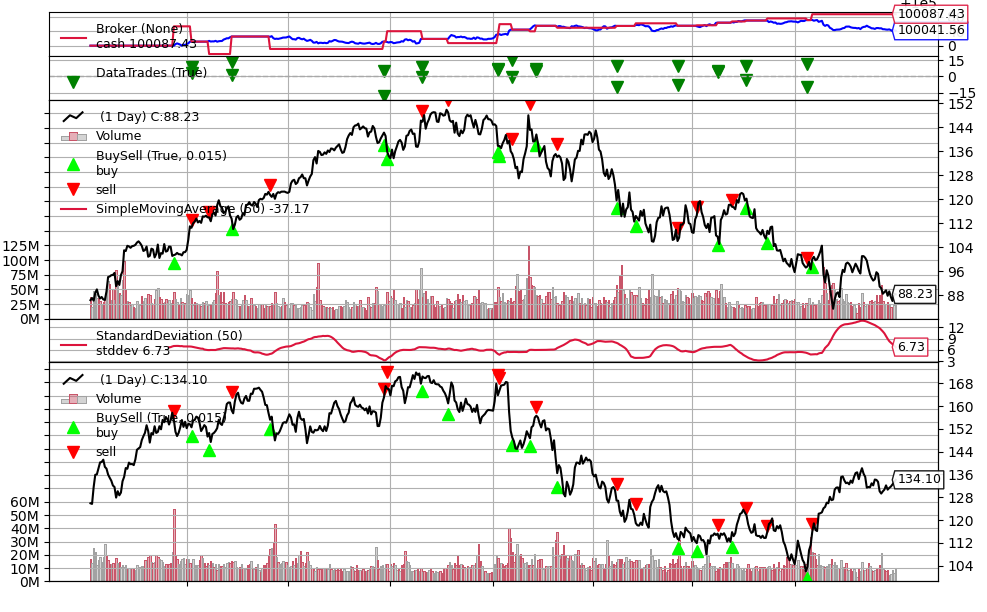

[[<Figure size 640x480 with 7 Axes>]]

In [14]:
class MeanReversionStrategy(bt.Strategy):
    params = (('stddev_factor', 1.5), ('lookback_period', 50))

    def __init__(self):
        # Calculate the spread between the log prices of the two stocks
        self.spread = self.data0 - self.data1
        self.mean = bt.indicators.SimpleMovingAverage(self.spread, period=self.p.lookback_period)
        self.stddev = bt.indicators.StandardDeviation(self.spread, period=self.p.lookback_period)

    def next(self):
        upper_band = self.mean[0] + self.p.stddev_factor * self.stddev[0]
        lower_band = self.mean[0] - self.p.stddev_factor * self.stddev[0]

        # Check if spread is above upper band (long JPM, short GS)
        if self.spread[0] > upper_band and not self.position:
            self.sell(data=self.data0, size=1)
            self.buy(data=self.data1, size=1)

        # Check if spread is below lower band (short JPM, long GS)
        elif self.spread[0] < lower_band and not self.position:
            self.buy(data=self.data0, size=1)
            self.sell(data=self.data1, size=1)

        # Exit the position when the spread returns to the mean
        elif self.spread[0] > self.mean[0] and self.position.size > 0:
            self.close(data=self.data0)
            self.close(data=self.data1)

        elif self.spread[0] < self.mean[0] and self.position.size < 0:
            self.close(data=self.data0)
            self.close(data=self.data1)

# Download data
data0 = bt.feeds.PandasData(dataname=yf.download('GOOGL', '2021-01-01', '2023-01-01'))
data1 = bt.feeds.PandasData(dataname=yf.download('JPM', '2021-01-01', '2023-01-01'))

# Initialize Cerebro engine
cerebro = bt.Cerebro()
cerebro.addstrategy(MeanReversionStrategy)
cerebro.adddata(data0)
cerebro.adddata(data1)

# Set initial cash and commission
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

# Run the strategy
results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()
print(f"Final Portfolio Value: {final_portfolio_value}")

# Plotting (optional)
cerebro.plot()

In [13]:
class MeanReversionStrategy(bt.Strategy):
    params = (('stddev_factor', 1.5), ('lookback_period', 50))

    def __init__(self):
        self.spread = self.data0 - self.data1
        self.mean = bt.indicators.SimpleMovingAverage(self.spread, period=self.p.lookback_period)
        self.stddev = bt.indicators.StandardDeviation(self.spread, period=self.p.lookback_period)

    def next(self):
        upper_band = self.mean[0] + self.p.stddev_factor * self.stddev[0]
        lower_band = self.mean[0] - self.p.stddev_factor * self.stddev[0]

        if self.spread[0] > upper_band and not self.position:
            self.sell(data=self.data0, size=1)
            self.buy(data=self.data1, size=1)
        elif self.spread[0] < lower_band and not self.position:
            self.buy(data=self.data0, size=1)
            self.sell(data=self.data1, size=1)
        elif self.spread[0] > self.mean[0] and self.position.size > 0:
            self.close(data=self.data0)
            self.close(data=self.data1)
        elif self.spread[0] < self.mean[0] and self.position.size < 0:
            self.close(data=self.data0)
            self.close(data=self.data1)

# Download data
data0 = bt.feeds.PandasData(dataname=yf.download('GOOGL', '2010-01-01', '2022-01-01'))
data1 = bt.feeds.PandasData(dataname=yf.download('JPM', '2010-01-01', '2022-01-01'))

# Optimization function
def run_strategy(stddev_factor, lookback_period):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MeanReversionStrategy, stddev_factor=stddev_factor, lookback_period=lookback_period)
    cerebro.adddata(data0)
    cerebro.adddata(data1)
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    results = cerebro.run()
    final_value = cerebro.broker.getvalue()
    return final_value

# Parameter grid
stddev_factors = [1.5, 2.0, 2.5, 3.0]
lookback_periods = [20, 30, 40, 50]

# Run optimization
best_value = 0
best_params = (None, None)

for stddev_factor in stddev_factors:
    for lookback_period in lookback_periods:
        value = run_strategy(stddev_factor, lookback_period)
        if value > best_value:
            best_value = value
            best_params = (stddev_factor, lookback_period)

print(f"Best Value: {best_value}")
print(f"Best Parameters: Stddev Factor = {best_params[0]}, Lookback Period = {best_params[1]}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Best Value: 100065.34511016842
Best Parameters: Stddev Factor = 1.5, Lookback Period = 50
